<a href="https://colab.research.google.com/github/wth666/JANC_test/blob/main/examples/janc_basic_example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install JANC and import relevant libraries

In [39]:
# Copyright © 2025 Haocheng Wen, Faxuan Luo
# SPDX-License-Identifier: MIT

!pip install git+https://github.com/wth666/JANC_test.git
!wget https://raw.githubusercontent.com/JA4S/JANC/main/examples/9sp-19r-H2-Air.yaml

  Cloning https://github.com/wth666/JANC_test.git to /tmp/pip-req-build-5fss8grd
  Running command git clone --filter=blob:none --quiet https://github.com/wth666/JANC_test.git /tmp/pip-req-build-5fss8grd
  Resolved https://github.com/wth666/JANC_test.git to commit 6eb7bdd223bf27ffb8b30a56fbf71b3ebf4afd48
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/JA4S/JAX-AMR.git to /tmp/pip-install-p0w9m99t/jaxamr_8070a602c87742ce9496bd50baec2b4b
  Running command git clone --filter=blob:none --quiet https://github.com/JA4S/JAX-AMR.git /tmp/pip-install-p0w9m99t/jaxamr_8070a602c87742ce9496bd50baec2b4b
  Resolved https://github.com/JA4S/JAX-AMR.git to commit b14c2f9d2750dcf00c69edbf990e3e5be57b3ab5
  Preparing metadata (setup.py) ... done
--2025-05-05 08:45:30--  https://raw.githubusercontent.com/JA4S/JANC/main/examples/9sp-19r-H2-Air.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw

In [40]:
from janc.thermodynamics import thermo
from janc.solver import solver
from janc.preprocess import nondim
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# set JAX to use GPU
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')

# Example : H2-Air Premixed RDC

# Set nondimension parameters and grid

In [41]:
#JANC support nondimension calculations
#it requires user to define the following reference values:
#reference pressure:P0 (Pa)
#reference temperature:T0 (K)
#reference length:x0 (m)
#reference gas constant:R0 (J/(kg·K))

#other reference values are automatically computed(【you don't need to define them】), including:
#reference density:rho0 (kg/m3)
#reference mole mass:M0 (kg/mol)
#reference specific internal energy:e0 (J/kg)
#reference velocity:u0 (m/s)
#reference time:t0 (s)

#you can access all the reference values by calling nondim.x, for example, t0 = nondim.t0

P0 = 10*101325 #pressure of injection manifold
T0 = 300    #tempreature of injection manifold
R0 = 369    #gas constant for H2-Air mixture with equivalence ratio 1.0
x0 = 0.08    #axial length of the combustor

nondim_config = {'P0':P0,
          'T0':T0,
          'R0':R0,
          'x0':x0}
nondim.set_nondim(nondim_config)
#when using nondimension calculation, make sure every input quantity
#is nondimensionalized, 【especially dx, dy and dt】
#Besides, any user defined functions, such as boundary conditions and source terms,
#【should have both nondimensional inputs and outputs】.

Lx = 0.20/x0
Ly = 0.08/x0

nx = 2000
ny = 800

dx = Lx/nx
dy = Ly/ny

x = jnp.linspace(0, Lx, nx)
y = jnp.linspace(0, Ly, ny)
X, Y = jnp.meshgrid(x, y, indexing='ij')

# Set thermodynamics (thermo & chemical properties) of gas mixture

In [42]:
thermo_config = {'is_detailed_chemistry':True,
        'thermo_model':'nasa7',
        'mechanism_diretory':'9sp-19r-H2-Air.yaml'}

#JANC thermo libraries are important part of nondimension calculations
#therefore, make sure to 【pass nondim_config to set_thermo】
#if you called set_nondim before set_thermo, nondim parameters are automatically read by set_thermo
#but in-order to prevent your code from execution-order-dependent, pass nondim_config to set_thermo will always be safe.
thermo.set_thermo(thermo_config,nondim_config)

# Set boundary conditions

Here we present an easy example to implement user-defined boundary conditions.
In JANC, implementations of user-defined boudnary conditions are simple,there isn't any .py file to be modified.
All you need is to defiend a function right here, with following requirements:

In [43]:
#def usr_boundary(U_bd,aux_bd,theta=None):

##U_bd and aux_bd is 3 nearest layers of grids to the boundary

##for example, if this function is used on right boundary,
##the shape of U_bd and aux_bd would be (variable_num,3,ny),(2,3,ny),
##which means U_bd = U[:,-3:,:]
##if this function is used on bottom boundary,U_bd = U[:,:,0:3]

##theta is a pytree (dict) containing any parameters you might need to define your functions

##the outputs of this function is 3 layers of ghost cells,
##and they should have the same shapes as the inputs
#return U, aux


##inlet boundary
#injection equivalence ratio
ratio = 1.0
yH2inj = (ratio/8*0.232)/(1 + ratio/8*0.232)
yO2inj = 0.232/(1 + ratio/8*0.232)

from janc.solver.aux_func import U_to_prim
def bottom_boundary(U_bd, aux_bd, theta=None):
    #for bottom boundary (injection plane),the shape of U_bd is (flux_num,nx,3)
    #aux_bd shape is (2,nx,3), aux_bd[0:1]:gamma, aux_bd[1:2]:Tempreature
    #U_bd = U[:,:,0:3]
    #In this case, theta contains mass fractions of the injection properllants

    U_bd = U_bd/theta['AR'][0:1,:,0:3]

    U_in = U_bd[:,:,0:1]
    aux_in = aux_bd[:,:,0:1]
    rho_in,u_in,v_in,Y_in,p_in,a_in = U_to_prim(U_in,aux_in)
    T_in = aux_in[1:2,:,0:1]
    gamma_in = aux_in[1:2,:,0:1]
    _, _, h_in, R_in, _ = thermo.get_thermo(T_in,Y_in)

    #interior pressure < injection pressure: velocity inlet
    u_inj = jnp.zeros_like(u_in)
    Y_inj = theta['Yinj']
    v_inj, T_inj, h_inj, gamma_inj = inj_model(p_in,Y_inj)
    R_inj = thermo.get_R(Y_inj)
    rho_inj = p_in/(R_inj*T_inj)

    #interior pressure >= injection pressure: slip wall
    #injection is blocked
    mask_block = (p_in >= 1.0)
    rho_cor_in = jax.lax.select(mask_block,rho_in,rho_inj)
    u_cor_in = jax.lax.select(mask_block,u_in,u_inj)
    v_cor_in = jax.lax.select(mask_block,-v_in,v_inj)
    T_cor_in = jax.lax.select(mask_block,T_in,T_inj)
    p_cor_in = p_in
    h_cor_in = jax.lax.select(mask_block,h_in,h_inj)
    Y_cor_in = jax.lax.select(jnp.tile(mask_block,(theta['Yinj'].shape[0],1,1)),Y_in,Y_inj)
    gamma_cor_in = jax.lax.select(mask_block,gamma_in,gamma_inj)

    U_lower_bound_state = jnp.concatenate([rho_cor_in, rho_cor_in * u_cor_in, rho_cor_in * v_cor_in,
                        rho_cor_in*h_cor_in - p_cor_in + 0.5 * rho_cor_in * (u_cor_in ** 2 + v_cor_in ** 2),
                        rho_cor_in * Y_cor_in], axis=0)
    aux_lower_bound_state = jnp.concatenate([gamma_cor_in,T_cor_in], axis=0)

    U = jnp.tile(U_lower_bound_state,(1,1,3))
    aux = jnp.tile(aux_lower_bound_state,(1,1,3))

    U = U*theta['AR'][0:1,:,0:1]

    return U, aux


#injection model from Fievisohn et al.2017, see https://doi.org/10.2514/1.B36103 for details
#this is a pressure feedback function, using pressure from the interior grid to infer the velocity et al.
#(like velocity inlet in ANSYS FLUENT)
def inj_model(p,Y_inj):
    A1 = 1
    A3 = 5
    A2 = A3-A1
    R = thermo.get_R(Y_inj)
    gamma = 1.29
    C0 = jnp.sqrt(gamma*R*1.0)

    M = jnp.zeros_like(p)
    P1 = 1.0*(1+(gamma-1)/2*M**2)**(-gamma/(gamma-1))
    V1 = M*(1+(gamma-1)/2*M**2)**(-0.5)*C0
    MFC = A1*1.0/jnp.sqrt(1.0)*jnp.sqrt(gamma/R)*M*(1+(gamma-1)/2*M**2)**(-(gamma+1)/2/(gamma-1))
    A = 0.5
    P3 = p
    B = gamma/(gamma-1)*P3*A3/MFC
    C = -gamma/(gamma-1)*R*1.0
    V3 = (-B+jnp.sqrt(B**2-4*A*C))/(2*A)
    P2 = (MFC*(V3-V1)-P1*A1+P3*A3)/A2

    M1 = jnp.zeros_like(p)
    M2 = jnp.ones_like(p)
    p_cor = p

    for i in range(20):
        M = 0.5*(M1+M2)
        P1 = 1.0*(1+(gamma-1)/2*M**2)**(-gamma/(gamma-1))
        V1 = M*(1+(gamma-1)/2*M**2)**(-0.5)*C0
        MFC = A1*1.0/jnp.sqrt(1.0)*jnp.sqrt(gamma/R)*M*(1+(gamma-1)/2*M**2)**(-(gamma+1)/2/(gamma-1))
        A = 0.5
        B = gamma/(gamma-1)*P3*A3/MFC
        C = -gamma/(gamma-1)*R*1.0
        V3 = (-B+jnp.sqrt(B**2-4*A*C))/(2*A)
        P2 = (MFC*(V3-V1)-P1*A1+P3*A3)/A2

        M2 = jax.lax.select(P2>=P1,M,M2)
        M1 = jax.lax.select(P2<P1,M,M1)

    rho_cor = MFC/V3/A3
    v_cor = V3
    T_cor = p_cor/(R*rho_cor)
    _, gamma, h_cor, _, _ = thermo.get_thermo(T_cor,Y_inj)
    return v_cor, T_cor, h_cor, gamma


##inlet boundary
#injection equivalence ratio
ratio = 1.0
yH2inj = (ratio/8*0.232)/(1 + ratio/8*0.232)
yO2inj = 0.232/(1 + ratio/8*0.232)

Yinj = jnp.concatenate([jnp.array([yH2inj,yO2inj]),1e-20*jnp.ones((8-2))],axis=0)
Yinj_cor = jnp.expand_dims(Yinj,(1,2))
Yinj_cor = jnp.tile(jnp.expand_dims(Yinj,(1,2)),(1,nx+2*3,1))

##outlet boundary:pressure_outlet
#JANC has built-in pressure_outlet boundary conditions
#theta should contain 'Pb' when using pressure_outlet bc.
#back pressure
Pb = 101325/P0

A0 = 1
A1 = 2
A = (A1-A0)/Ly*Y + A0
gradA = jnp.full_like(X, fill_value=(A1-A0)/Ly)
AR = jnp.array([A,gradA])


theta = {'Yinj': jnp.tile(jnp.expand_dims(Yinj,(1,2)),(1,nx,1)),
      'Pb': Pb,
      'AR': AR}

boundary_config = {'left_boundary':'periodic',
           'right_boundary':'periodic',
           'bottom_boundary':bottom_boundary,
           'up_boundary':'pressure_outlet'}

# Initializations

In [44]:
thermo_config = {'is_detailed_chemistry':True,
         'thermo_model':'nasa7',
         'mechanism_diretory':'9sp-19r-H2-Air.yaml'}

advance_one_step, rhs = solver.set_solver(thermo_config,boundary_config)
#advance_one_step: time advance functions, advance current state one time step dt.
#rhs: right-hand side of the Euler-equations: dUdt = rhs,
#normally, 【advance_one_step is all you need】. However, when it comes to machine-learning tasks,
#rhs can be embedded in a differentiable optimization loop

solver is initialized successfully!


[[0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 ...
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]]
[[0.1        0.10012516 0.10025031 ... 0.19974968 0.19987484 0.2       ]
 [0.1        0.10012516 0.10025031 ... 0.19974968 0.19987484 0.2       ]
 [0.1        0.10012516 0.10025031 ... 0.19974968 0.19987484 0.2       ]
 ...
 [0.1        0.10012516 0.10025031 ... 0.19974968 0.19987484 0.2       ]
 [0.1        0.10012516 0.10025031 ... 0.19974968 0.19987484 0.2       ]
 [0.1        0.10012516 0.10025031 ... 0.19974968 0.19987484 0.2       ]]


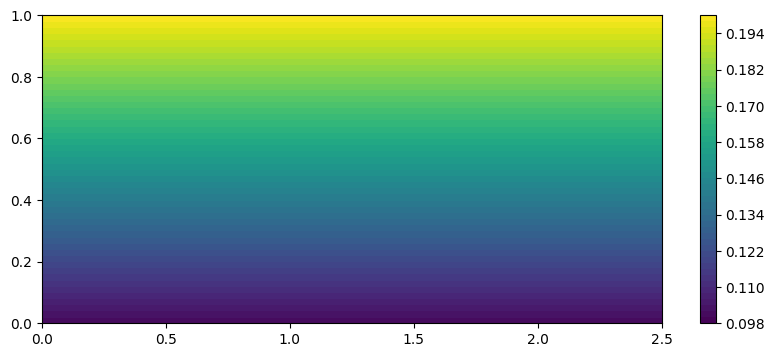

In [50]:
def initial_conditions():
    Penv = 1*101325/P0; Tenv = 300/T0; yH2env = 0; yO2env = 0.232;
    Pignition = 15*101325/P0; Tignition = 3000/T0;
    Yenv = jnp.array([yH2env,yO2env,0,0,0,0,0,0])
    Yfill = jnp.array([yH2inj,yO2inj,0,0,0,0,0,0])

    ignition_width = 108;ignition_height = 288

    Y_init = jnp.broadcast_to(Yenv[:,None,None],(8,nx,ny))
    Y_fill = jnp.broadcast_to(Yfill[:,None,None],(8, nx//2, ignition_height))
    #Y_init = Y_init.at[:, 0:nx//2, 0:ignition_height].set(Y_fill)

    T_init = jnp.full((1,nx,ny),Tenv)
    #T_init = T_init.at[:,0:ignition_width,0:ignition_height].set(Tignition)

    P_init = jnp.full((1,nx,ny),Penv)
    #P_init = P_init.at[:,0:ignition_width,0:ignition_height].set(Pignition)

    _,gamma_init,h_init,R_init,_ = thermo.get_thermo(T_init,Y_init)

    rho_init = P_init/(R_init*T_init)
    E_init = rho_init*h_init - P_init
    rhou_init = jnp.zeros((1,nx,ny))
    rhov_init = jnp.zeros((1,nx,ny))


    U_init = jnp.concatenate([rho_init,rhou_init,rhov_init,E_init,rho_init*Y_init],axis=0)
    aux_init = jnp.concatenate([gamma_init,T_init],axis=0)
    return U_init, aux_init

U, aux = initial_conditions()

#rho,u,v,Ys,p,a = U_to_prim(U,aux)
plt.figure(figsize=(10, 4))
plt.contourf(X, Y, aux[-1], levels=50, cmap='viridis')
plt.colorbar()


#print(U[5:6,:,:])
U = U*theta['AR'][0:1,:,:]
#print(U[5:6,:,:])



# Set Source Term

In [17]:
def pSource(U,aux,theta=None):
    U = U/theta['AR'][0:1,:,:]
    rho,u,v,Y,p,a = U_to_prim(U,aux)
    p_source = jnp.zeros_like(U)
    p_source = p_source.at[2:3,:,:].set(p*theta['AR'][1:2,:,:])
    return p_source
user_set = {'self_defined_source_terms': pSource}

# Main loop of time advance

In [37]:
##minimum implementations of 【advance_one_step】:
dt = 5e-9/(nondim.t0)
nt = 500
field = jnp.concatenate([U,aux],axis=0)
for step in tqdm(range(nt),desc="progress", unit="step"):
  field = advance_one_step(field,dx,dy,dt,theta)
  fieldVis = field/theta['AR'][0:1,:,:]

progress:   0%|          | 0/500 [00:00<?, ?step/s]

KeyboardInterrupt: 

# Plot

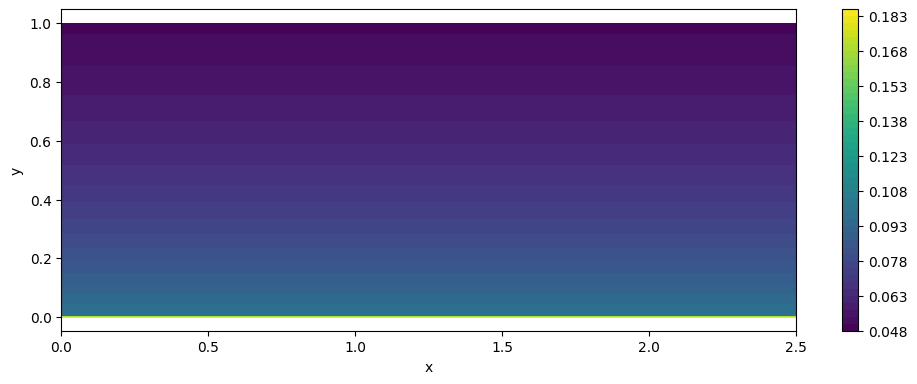

In [38]:
rho,u,v,Ys,p,a = U_to_prim(fieldVis[0:-2],fieldVis[-2:])
plt.figure(figsize=(10, 4))
#plt.contourf(X, Y, theta['AR'][0], levels=50, cmap='viridis')
plt.contourf(X, Y, p[0], levels=50, cmap='viridis')
#plt.clim(0, 4)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.tight_layout()
plt.axis('equal')
plt.show()